In [45]:
import pandas as pd
import numpy as np
import fasttext
import operator
import fasttext.util
from collections import defaultdict
import nltk
import math

In [2]:
sample = pd.read_csv('amostra.csv')

In [5]:
# load fasttext word embedding 
ft = fasttext.load_model('cc.pt.300.bin')

In [3]:
# create a dictionary of units and normalize units
std_units = list(set(sample['nm_un_fornec']))
com_units = list(set(sample['unid_comercial']))
unit_dict = {
 'UND':'UNIDADE',
 'pct':'PACOTE',
 'PC':'PACOTE',
 'un':'UNIDADE', 
 'UNID.':'UNIDADE',
 'PT':'UNIDADE',
 'kg':'QUILOGRAMA',
 'KG':'QUILOGRAMA',
 'PCT':'PACOTE',
 'DZ':'DUZIA',
 'FD':'FARDO',
 'GL':'GALAO',
 'FR':'FRASCO',
 'PCTE':'PACOTE',
 'pc':'PACOTE',
 'PÇ':'PACOTE',
 'DP':'DP',
 'dz':'DUZIA',
 'CX':'CAIXA',
 'PÇA':'PCA',
 'UN':'UNIDADE',
 'CAIXA':'CAIXA',
 'LT':'LITRO',
 '-':'-',
 'PCS':'PCS'
}
sample['unid_comercial'] =sample['unid_comercial'].apply(lambda x: unit_dict[x])

In [4]:
# normalize text and replace special characters
text_normal = {
    "Á":"A",
    "À":"A",
    "Ã":"A",
    "Â":"A",
    "É":"E",
    "È":"E",
    "Ê":"E",
    "Í":"I",
    "Ì":"I",
    "Î":"I",
    "Ó":"O",
    "Ò":"O",
    "Õ":"O",
    "Ô":"O",
    "Ú":"U",
    "Ù":"U",
    "Û":"U",
    "Ç":"C"
}

def normalize(string):
    s = ''
    alpha_num = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    for i in string:
        if i in text_normal.keys():
            s+=text_normal[i]
        elif i not in alpha_num:
            s+= ' '
        else:
            s+=i
    return s

sample['descr_prod'] =sample['descr_prod'].apply(lambda x: normalize(x))
sample['descr_item'] =sample['descr_item'].apply(lambda x: normalize(x))

In [62]:
# compile a list of candidate BEC codes
cod_dict = defaultdict(list)
cod_item = defaultdict(list)
for index,row in sample.iterrows():
    descr = row['descr_item'].split()
    unit = row['nm_un_fornec'].split()
    if row['cod_item'] not in cod_item[row['CODIGOLICITACAO']]:
        cod_dict[row['CODIGOLICITACAO']].append((row['cod_item'], descr+unit))
    cod_item[row['CODIGOLICITACAO']].append(row['cod_item'])
    
# compile a list of stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')
for i in range(len(stopwords)):
    stopwords[i] = normalize(stopwords[i].upper())
    
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

def match_BEC(s,l):
    s = [i for i in s if i not in stopwords]
    scores = {}
    for bec in l:
        temp = [i for i in bec[1] if i not in stopwords]
        scores[bec[0]] = jaccard(s,temp)
    sorted_dict = sorted(scores.items(), key=operator.itemgetter(1))
    if len(sorted_dict) > 1 and sorted_dict[-2][1] != 0:
        conf_score = (sorted_dict[-1][1]-sorted_dict[-2][1])/sorted_dict[-2][1]
    elif len(sorted_dict) > 1 and sorted_dict[-2][1] == 0 and sorted_dict[-1][1] != 0:
        conf_score = 1000
    elif len(sorted_dict) > 1 and sorted_dict[-2][1] == 0 and sorted_dict[-1][1] == 0:
        conf_score = 0
    else:
        conf_score = np.nan
    return max(scores.items(), key=operator.itemgetter(1))[0], conf_score
match_dict = defaultdict(int)
conf_scores = defaultdict(float)
for index,row in sample.iterrows():
    descr = row['descr_prod'].split()
    unit = row['unid_comercial'].split()
    s = descr+unit
    match_dict[index],conf_scores[index] = match_BEC(s,cod_dict[row['CODIGOLICITACAO']])

In [68]:
count_nan = 0
count_max = 0
count_0 = 0
other_scores = []
for i in conf_scores.values():
    if math.isnan(i):
        count_nan+=1
    elif i==1000:
        count_max+=1
    elif i==0:
        count_0+=1
    else:
        other_scores.append(i)

/Users/xichen/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Density'), Text(0.5, 0, 'confidence score')]

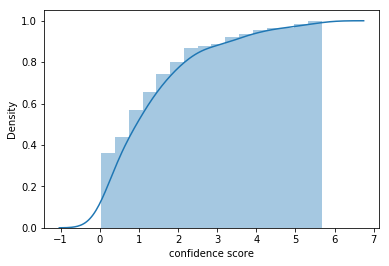

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ax = sns.histplot(x=other_scores)
# ax.set(xlabel='confidence score')

kwargs = {'cumulative': True}
ax = sns.distplot(other_scores, hist_kws=kwargs, kde_kws=kwargs)
ax.set(xlabel='confidence score', ylabel='Density')


In [75]:
other_scores

[0.24999999999999994,
 0.11764705882352951,
 0.8529411764705884,
 0.041666666666666706,
 0.9285714285714286,
 4.3125,
 0.24999999999999994,
 0.11764705882352951,
 0.8529411764705884,
 0.041666666666666706,
 0.9285714285714286,
 4.3125,
 0.24999999999999994,
 0.11764705882352951,
 0.8529411764705884,
 0.041666666666666706,
 0.9285714285714286,
 4.3125,
 0.24999999999999994,
 0.11764705882352951,
 0.8529411764705884,
 0.041666666666666706,
 0.9285714285714286,
 4.3125,
 0.24999999999999994,
 0.11764705882352951,
 0.8529411764705884,
 0.041666666666666706,
 0.9285714285714286,
 4.3125,
 0.24999999999999994,
 0.11764705882352951,
 0.8529411764705884,
 0.041666666666666706,
 0.9285714285714286,
 4.3125,
 1.8125,
 0.3421052631578947,
 1.8125,
 0.3421052631578947,
 2.0,
 2.0,
 1.357142857142857,
 2.0,
 2.0,
 1.357142857142857,
 2.0,
 2.0,
 1.357142857142857,
 0.4666666666666666,
 2.5,
 3.1249999999999996,
 1.0,
 0.8461538461538464,
 2.142857142857143,
 0.4666666666666666,
 2.5,
 3.12499999999

# Calculate distinct BEC codes

In [73]:
sample = pd.read_csv('descriptions_1920.csv')

In [74]:
BEC_count = defaultdict(list)
item_count = defaultdict(int)
for index,row in sample.iterrows():
    if row['descr_item'] not in BEC_count[row['codigo']]:
        BEC_count[row['codigo']].append(row['descr_item'])
    item_count[row['codigo']] += 1
    if index % 100000 == 0:
        print(index)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000


In [76]:
for i in BEC_count:
    BEC_count[i] = len(BEC_count[i])

In [94]:
matrix = np.zeros((26,12))
for i in item_count:  
    if item_count[i] >= 26:
        count = 26
    else:
        count = item_count[i]
    if BEC_count[i] >= 12:
        bec = 12
    else:
        bec = BEC_count[i]
    matrix[count-1][bec-1]+=1

In [101]:
matrix = matrix.astype(int)
np.savetxt('table.csv', matrix, fmt="%d", delimiter=",")


/Users/xichen/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Density'), Text(0.5, 0, '#distinct BEC codes')]

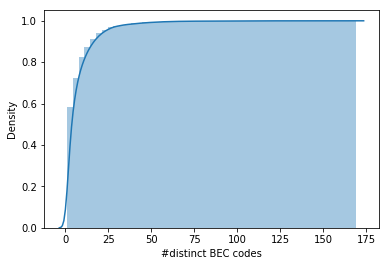

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

kwargs = {'cumulative': True}
ax = sns.distplot(list(BEC_count.values()), hist_kws=kwargs, kde_kws=kwargs)
ax.set(xlabel='#distinct BEC codes', ylabel='Density')


In [29]:
item_bec = defaultdict(list)
for i in item_count:
    item_bec[item_count[i]].append(BEC_count[i])